# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W0901',
    #'2023W0801',
    #'2023W0704',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-13 05:42:09.662410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 05:42:11.887170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-13 05:42:11.888396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-13 05:42:11.889441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-03-13 05:42:14,772[INFO][139707097438016-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 192.168.2.236:6379
[2023-03-13 05:42:14,890 I 29498 29498] global_state_accessor.cc:357: This node has an IP address of 172.18.12.180, while we can not found the matched Raylet address. This maybe come from when you connect the Ray cluster with a different IP address or connect a container.
2023-03-13 05:42:15,687[INFO][139707097438016-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-13 05:42:15,688[INFO][139707097438016-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 70.38it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

,label,count()
0,0.0,52575
1,1.0,48318


## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,0.999329,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.0,1.0,0.000000,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,1.0,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.000000,0.000000,0.964028,0.964028,0.995055,0.0,1.0,0.0
1,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.999988,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
2,0.0,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.0,1.0,0.761594,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.0,1.0,1.000000,0.999988,0.964028,0.000000,1.0,0.0,0.0,1.000000,0.761594,0.000000,0.000000,0.995055,0.0,1.0,0.0
3,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.999988,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
4,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.761594,1.0,0.0,0.964028,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.999988,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.761594,0.761594,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.999988,0.000000,0.761594,1.0,0.0,0.0,0.000000,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
100796,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,1.0,1

In [8]:
L_predict[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.0,100800.000000,100800.0,100800.000000,100800.000000,100800.0,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.0,100800.0,1.008000e+05,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.0,100800.000000,100800.000000,100800.000000,1.008000e+05,100800.0,100800.0,100800.0,100800.0,100800.000000,100800.000000,100800.000000,100800.00000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,1.008000e+05,100800.000000,100800.000000,100800.0,100800.000000,100800.0,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.000000,100800.0
mean,0.479276,0.960490,0.271181,0.271181,0.271181,0.217882,0.323410,0.323413,0.736687,0.708165,0.708165,0.695579,0.678737,0.708165,0.633259,0.633162,0.092295,0.604671,0.323409,0.422407,0.0,0.633162,0.0,0.000067,0.215466,1.0,0.000058,0.288544,0.715614,0.999960,0.999960,0.999960,0.979170,0.762215,0.756523,0.697106,0.0,0.0,1.000000e+00,0.965593,0.965593,0.957529,0.731601,0.965593,0.718248,0.717727,0.065437,0.689208,0.0,0.684059,0.187067,0.717727,1.000000e+00,0.0,1.0,1.0,1.0,0.288313,0.679544,0.922044,0.72823,0.727103,0.009314,0.724938,0.724108,0.727496,9.999878e-01,0.708317,0.232264,1.0,0.632694,0.0,0.714822,0.200538,0.316754,0.728718,0.983089,0.633269,0.718863,0.0
std,0.499573,0.140330,0.444571,0.444571,0.444571,0.412805,0.467778,0.467781,0.440433,0.454609,0.454609,0.460073,0.466954,0.454609,0.481843,0.481862,0.289356,0.474622,0.467775,0.427552,0.0,0.481862,0.0,0.007603,0.354418,0.0,0.007575,0.372957,0.443158,0.008909,0.008909,0.008909,0.167988,0.425675,0.314331,0.449692,0.0,0.0,7.085567e-09,0.182267,0.182267,0.204937,0.443072,0.182267,0.449044,0.449188,0.244749,0.452967,0.0,0.386147,0.327835,0.449188,1.697976e-08,0.0,0.0,0.0,0.0,0.452980,0.466654,0.268104,0.44408,0.444318,0.093944,0.445447,0.446116,0.444237,9.270577e-07,0.445116,0.374486,0.0,0.481869,0.0,0.451166,0.335431,0.454055,0.437471,0.044401,0.481848,0.449260,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.0,0.0,9.999998e-01,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.999998e-01,0.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.00000,

In [9]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.999329,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.000000,0.964028,0.964028,0.995055,0.0,1.0,0.0
1,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999988,0.000000,0.0,1.0,0.0,0.0,0.0,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
2,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.964028,0.0,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.995055,0.0,1.0,0.0
3,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999988,0.000000,0.0,1.0,0.0,0.0,0.0,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
4,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.761594,1.0,0.0,0.964028,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999988,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.761594,0.761594,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.999329,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.761594,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.000000,0.964028,0.964028,0.995055,0.0,1.0,0.0
96,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999988,0.000000,0.0,1.0,0.0,0.0,0.0,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
97,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.999909,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.999909,1.0,1.0,0.999998,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,1.000000,0.0,1.0,1.0,0.0,1.0,0.000000,0.964028,1.000000,1.000000,1.0,1.0,0.0
98,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999988,0.000000,0.0,1.0,0.0,0.0,0.0,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0


In [10]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,100.0,100.00000,100.000000,100.000000,100.0,100.00000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.00000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.00,100.0,100.00,100.0,100.000000,100.000000,100.00,100.0,100.0,100.0,100.0,100.0,100.000000,100.000000,100.00,100.00000,100.000000,100.0,100.00000,100.00000,100.00000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00,100.0
mean,0.984610,0.130000,0.130000,0.130000,0.060000,0.170000,0.170000,0.500000,0.440000,0.440000,0.429991,0.190000,0.440000,0.21000,0.21000,0.0,0.21000,0.170000,0.406486,0.0,0.21000,0.0,0.0,0.116263,1.0,0.0,0.728045,0.57000,1.0,1.0,1.0,0.972369,0.590000,0.937767,0.467495,0.0,0.0,1.0,0.940000,0.940000,0.940000,0.590000,0.940000,0.55,0.55,0.0,0.55,0.0,0.904782,0.060928,0.55,1.0,0.0,1.0,1.0,1.0,0.140000,0.500000,0.99,0.57000,0.570000,0.0,0.57000,0.57000,0.57000,0.999988,0.502978,0.007616,1.0,0.209999,0.0,0.54959,0.380797,0.424172,0.476604,0.971462,0.21000,0.55,0.0
std,0.017292,0.337998,0.337998,0.337998,0.238683,0.377525,0.377525,0.502519,0.498888,0.498888,0.497560,0.394277,0.498888,0.40936,0.40936,0.0,0.40936,0.377525,0.464771,0.0,0.40936,0.0,0.0,0.278850,0.0,0.0,0.191049,0.49757,0.0,0.0,0.0,0.201681,0.494311,0.196088,0.433234,0.0,0.0,0.0,0.238683,0.238683,0.238683,0.494311,0.238683,0.50,0.50,0.0,0.50,0.0,0.240641,0.207656,0.50,0.0,0.0,0.0,0.0,0.0,0.348735,0.502519,0.10,0.49757,0.497569,0.0,0.49757,0.49757,0.49757,0.000000,0.447133,0.076159,0.0,0.409358,0.0,0.49964,0.382715,0.480941,0.481780,0.055565,0.40936,0.50,0.0
min,0.964028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.00000,1.0,1.0,1.0,-0.761594,0.000000,0.169737,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.00,0.0,0.093990,0.000000,0.00,1.0,0.0,1.0,1.0,1.0,0.000000,0.000000,0.00,0.00000,0.000000,0.0,0.00000,0.00000,0.00000,0.999988,0.000000,0.000000,1.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.761594,0.00000,0.00,0.0
25%,0.964028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,1.0,0.0,0.761594,0.00000,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.00,0.00,0.0,0.00,0.0,1.000000,0.000000,0.00,1.0,0.0,1.0,1.0,1.0,0.000000,0.000000,1.00,0.00000,0.000000,0.0,0.00000,0.00000,0.00000,0.999988,0.000000,0.000000,1.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.964028,0.00000,0.00,0.0
50%,0.997192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.00000,0.000000,0.038488,0.0,0.00000,0.0,0.0,0.000000,1.0,0.0,0.761594,1.00000,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.761594,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.00,0.0,1.00,0.0,1.000000,0.000000,1.00,1.0,0.0,1.0,1.0,1.0,0.000000,0.500000,1.00,1.00000,1.000000,0.0,1.00000,1.00000,1.00000,0.999988,0.761594,0.000000,1.0,0.000000,0.0,1.00000,0.380797,0.000000,0.380797,0.995055,0.00000,1.00,0.0
75%,0.999329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.0,0.00000,0.000000,1.000000,0.0,0.00000,0.0,0.0,0.000000,1.0,0.0,0.761594,1.00000

In [11]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [12]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,0.495040,0.484127,0.484127,0.476190,0.468254,0.484127,0.462302,0.462302,0.470238,0.480159,0.474206,0.490079,0.482143,0.485119,0.490079,0.470238,0.471230,0.482143,0.476190,0.465278,0.485119,0.484127,0.465278,0.501984,0.487103,0.508929,0.498016,0.474206,0.488095,0.503968,0.485119,0.470238,0.465278,0.490079,0.469246,0.459325,0.483135,0.476190,0.470238,0.478175,0.486111,0.478175,0.478175,0.467262,0.474206,0.493056,0.448413,0.468254,0.460317,0.487103,0.477183,0.472222,0.482143,0.478175,0.471230,0.481151,0.471230,0.486111,0.503968,0.469246,0.489087,0.503968,0.483135,0.494048,0.488095,0.490079,0.500992,0.492063,0.480159,0.478175,0.463294,0.467262,0.470238,0.474206,0.476190,0.465278,0.482143,0.458333,0.486111,0.475198,0.476190,0.493056,0.478175,0.479167,0.492063,0.478175,0.485119,0.474206,0.470238,0.487103,0.496032,0.462302,0.487103,0.468254,0.490079,0.484127,0.471230,0.469246,0.483135,0.453373
std,0.500224,0.499996,0.499996,0.499681,0.499239,0.499996,0.498824,0.498824,0.499361,0.499854,0.499582,0.500150,0.499929,0.500027,0.500150,0.499361,0.499419,0.499929,0.499681,0.499041,0.500027,0.499996,0.499041,0.500244,0.500082,0.500168,0.500244,0.499582,0.500106,0.500232,0.500027,0.499361,0.499041,0.500150,0.499301,0.498590,0.499964,0.499681,0.499361,0.499771,0.500055,0.499771,0.499771,0.499175,0.499582,0.500200,0.497579,0.499239,0.498670,0.500082,0.499727,0.499476,0.499929,0.499771,0.499419,0.499893,0.499419,0.500055,0.500232,0.499301,0.500129,0.500232,0.499964,0.500213,0.500106,0.500150,0.500247,0.500185,0.499854,0.499771,0.498898,0.499175,0.499361,0.499582,0.499681,0.499041,0.499929,0.498508,0.500055,0.499632,0.499681,0.500200,0.499771,0.499814,0.500185,0.499771,0.500027,0.499582,0.499361,0.500082,0.500232,0.498824,0.500082,0.499239,0.500150,0.499996,0.499419,0.499301,0.499964,0.498068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

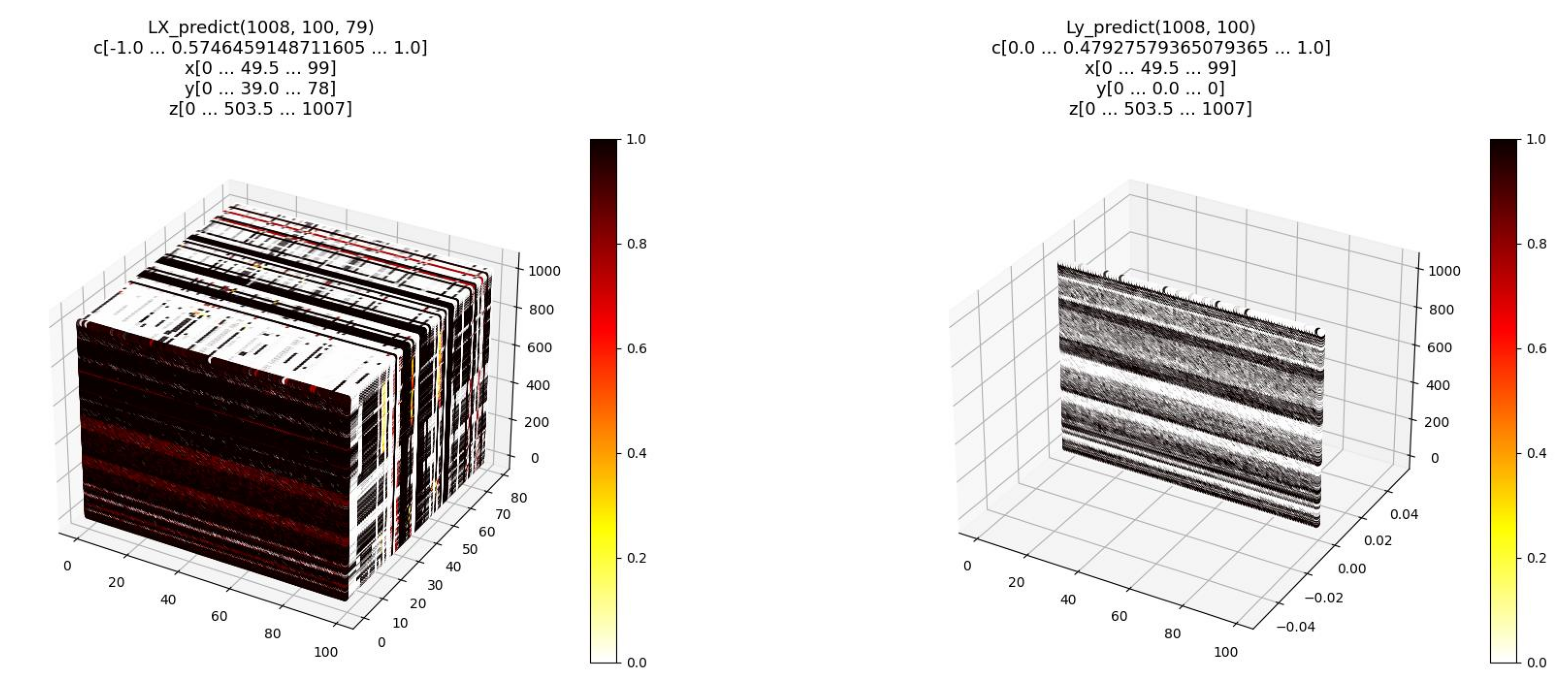

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-03-13 05:48:44.965259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-13 05:48:44.966010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-13 05:48:44.966718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-13 05:48:44.967430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0901             47510                801            52222               267     99732       1068       0.989405        0.010595


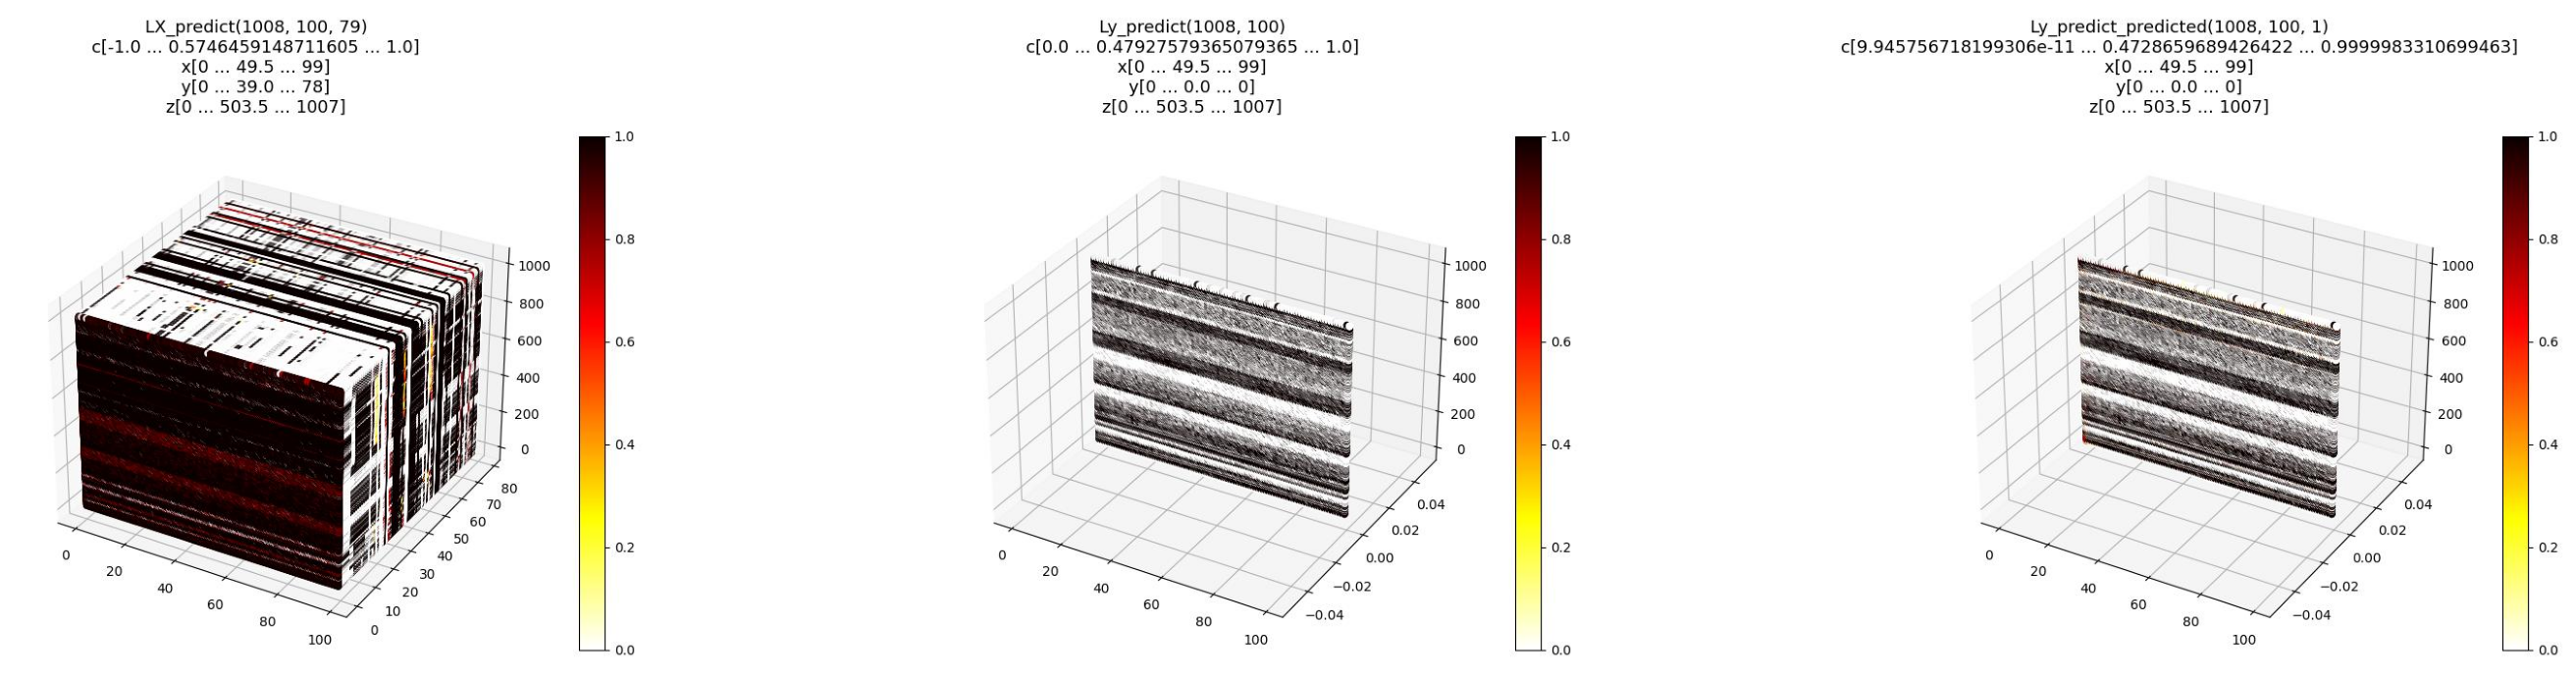

,checkpoint,anomaly_detected,anomaly_incorrect,benign_detected,benign_incorrect,detected,incorrect,detected_rate,incorrect_rate
0,2023W0901,47510,801,52222,267,99732,1068,0.989405,0.010595


In [16]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df